# Taking the Low Road: Floodplain Connectivity in Boulder, CO
Restoring floodplain connectivity encourages water to flow into side channels and ponds, which ultimately mitigates the impact of heavy flooding. We investigated different methods to visualize this process through aerial imagery (drones), elevation models (LiDAR), histograms, and simulations. Our results can be used to help land-use planners design and implement restoration practices in the St. Vrain watershed.

**Collaborators and Acknowledgements**<br>
Lindsay Chipman, Julia Sobczak, Matthew Bitters, and [The Watershed Center](https://watershed.center/). This notebook constitues the final project for the University of Colorado Earth Data Analytics Professional Certificate, special thanks to the [Earth Lab](https://www.earthdatascience.org/) and Dr. Elsa Culler!

<img src="https://github.com/JuliaSobczak/st-vrain-rem/blob/main/media/LG_02.JPG?raw=true" height=80%/>

Image source: Julia Sobczak 2023

## Introduction: What is a floodplain?
A **floodplain** is the area adjacent to a stream that becomes inundated with water when a flood occurs. This space allows the flood to spread out and release energy and suspended objects such as sediment, logs, and debris. By reducing the flow of water down the stream corridor, floodplains effectively mitigate destruction to buildings and other infrastructure downstream (FISRWG 1998). 

<img src="https://github.com/JuliaSobczak/st-vrain-rem/blob/main/media/floodplain.JPG?raw=true" width="50%"/>

Image Source: American Rivers 2016


BUT this can only happen if the floodplain is "available" to the stream, i.e., if the area around the stream is low enough to be inundated when floodwaters occur. If a floodplain is situated above the highest flow of water, it will not be accessible by the stream - we call this a **disconnected floodplain** (American Rivers 2016).

On the left is one of our study sites: Apple Valley. Notice how there is only one channel of water and the land around the stream is relatively high; this plain is inaccessible to the stream. If a large flood ran through here, the water would funnel down the "shoot" with dangerous strength and speed encouraging erosion and destruction. On the right is our Legacy 1 site where one can observe more complexity and side channels for the water to follow. If flooding occured here, the water would flow into the many side channels and ponds which reduces its speed and encourages suspended objects to "drop" onto the land instead of continuing downstream.

<img src="https://github.com/JuliaSobczak/st-vrain-rem/blob/main/media/AV_02.JPG?raw=true" style="margin:2px" align="left" width="49%"/>
<img src="https://github.com/JuliaSobczak/st-vrain-rem/blob/main/media/LG_03.JPG?raw=true" style="margin:2px" width="49%"/>

Image source: Julia Sobczak 2023

# Summary
A **connected floodplain** is an area near the stream that can accept floodwaters and act as a buffer to potentially dangerous flows down the stream corridor. A well-connected floodplain can help save infrastructure and increase habitat resiliency to destructive flooding events by (FISRWG 1998):
* Dispersing the force of a flood, which reduces destruction to man-made structures along the stream
* Maintaining water quality by reducing sediment/fine particles flowing downstream
* Reducing erosion via plants and plant roots growing along the banks (encouraged by nutrients from floodwaters)
* Capturing high levels of carbon due to the physical properties of wetland soil

In [1]:
# Import packages
import os
import pathlib
import zipfile
from plot_site_map import plot_sites_folium
import geopandas as gpd
from IPython.display import clear_output
import load_model
import matplotlib.pyplot as plt
import numpy as np
from riverrem.REMMaker import REMMaker, clear_osm_cache
import requests
import rioxarray as rxr
from rioxarray.merge import merge_arrays
from time import sleep

In [2]:
# Set working directory
working_dir = os.path.join(
    pathlib.Path.home(), 'st-vrain-rem-wkdir', 'data')

# Try/Except Block   
# Print statements commented out for html export
try:
    os.chdir(working_dir)
except:
    #print('{} does not exist. Creating...'.format(working_dir))
    os.makedirs(working_dir)
    os.chdir(working_dir)
#else:
    #print('{} is now the working directory'.format(working_dir))

## Study Sites: St. Vrain Watershed (Boulder, CO)
Our five study sites lay within the St. Vrain Watershed which is located in the northwest foothills of Colorado, USA. This is a heavily populated area with beautiful views and lots of opportunity for outdoor recreation including hiking, kayaking, and mountain biking. Many homes are situated in floodplains, which can be dangerous for residents when heavy flooding occurs as evidenced by the [2013 Boulder flood](https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/colorado-floods-2013/).

In [3]:
# Run plot site map
plot_sites_folium()

/Users/lchipman/opt/miniconda3/envs/earth-analytics-py2/lib/python3.10/site-packages/folium/utilities.py:69: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
/Users/lchipman/opt/miniconda3/envs/earth-analytics-py2/lib/python3.10/site-packages/folium/utilities.py:77: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
/Users/lchipman/opt/miniconda3/envs/earth-analytics-py2/lib/python3.10/site-packages/folium/utilities.py:79: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(x) for x in coords]


## Methods - Using Elevation Models to Evaluate Floodplain Connectivity

Models of floodplain elevation can be used to investigate surface characteristics, estimate connectivity and complexity, and predict where water will flow. A **Digital Terrain Model (DTM)** is a representation of the topographic surface of the Earth excluding trees, buildings, and any other surface objects. A **Relative Elevation Model (REM)** is a DTM normalized to the stream channel. REMs are used to visualize fluvial landforms that may be hard to discern from an aerial image or DTM alone.

We obtained images of the study sites from drones or **Unmanned Aerial Vehicles (UAVs)** that the Watershed Center captured in 2022. From these UAV images, we created DTMs using the software [Agisoft Metashape](https://www.agisoft.com/), which performs photogrammetric processing of digital images to generate 3D spatial data. We then created REMs from these DTMs using two methods:
1. [REM Generator Tool](https://drive.google.com/drive/folders/1qcsaKrh-NPplq4P3escRgNW6mokA_QLL). This is a free tool available from the [Colorado Water Conservation Board's Colorado Fluvial Hazard Zone Program](https://www.coloradofhz.com/). However, it requires an ArcGIS license to run.
2. [REMMaker](https://github.com/OpenTopography/RiverREM/blob/main/riverrem/REMMaker.py) tool available on github at [RiverREM](https://github.com/OpenTopography/RiverREM/tree/main). This is an open-source python tool.

The images below are the high-resolution REMs we created from the UAV images using the 'REM Generator Tool' in ArcMap. The cooler colors represent lower elevations and reveal features such as the main channel, side channels, depressions, and pools. The hotter colors represent higher elevations and show features such as slopes, hills, and at some sites, such as  Legacy 1, canyon walls.

<img src="https://github.com/JuliaSobczak/st-vrain-rem/blob/main/media/legacy_ortho_rem.png?raw=true" height = 80%/>
<img src="https://github.com/JuliaSobczak/st-vrain-rem/blob/main/media/vanvleet_ortho_rem.png?raw=true" height=80%/>
<img src="https://github.com/JuliaSobczak/st-vrain-rem/blob/main/media/hallmeadows_ortho_rem.png?raw=true" height=80%/>
<img src="https://github.com/JuliaSobczak/st-vrain-rem/blob/main/media/highway93_ortho_rem.png?raw=true" height=80%/>
<img src="https://github.com/JuliaSobczak/st-vrain-rem/blob/main/media/applevalley_ortho_rem.png?raw=true" height=80%/>

## Methods - Visualizing the UAV and LiDAR DTMs with Raster Plots and Histograms
We wanted to compare DTMs obtained from different data sources to investigate floodplain connectivity. Therefore, in addition to the drone-derived REMs shown above, we created REMs using DTMs generated from Light Detection and Ranging or **LiDAR**, which is a remote sensing method used to examine the surface of the Earth. LiDAR data overlaying our study sites was available on the [Colorado Hazard Mapping & RiskMAP Portal](https://coloradohazardmapping.com/).

The plots below show the DTMs and their histograms (frequency plots) for two contrasting sites - Apple Valley, which is a relatively less complex/connected site, and Highway 93, which is more complex and connected as indicated by the presence of side channels, pools, and other features. The similarity of the DTMs and histograms is an indicator that so far, the two methods (UAV and LiDAR) are performing comparably with respect to their ability to discern elevational changes on the Earth's surface. Notice that the units of the plots are different - the LiDAR DTMs are in feet, while the UAV DTMs are in meters. We convert the units before generating the REMs in the next step for easier comparison.

In [4]:
# Call the function to create dictionaries for the sites.
site_names = ['applevalley', 'highway93']
site_lidar_urls = load_model.get_lidar_url(site_names=site_names)

# Download and unzip lidar, save the lidar DTMs to the dictionaries
for site in site_lidar_urls:
    site['lidar_dtm'] = load_model.load_dtm(data_url=site['lidar_url'], 
                                     site_name=site['site_name'],
                                     file_name=site['zip_filename'])

In [5]:
# Load the Area of Interest (AOI)

# Call function to create bounding polygon gdf for each site, save to site_lidar_urls
shape_url = ('https://github.com/lechipman/watershed-project/'
                 'releases/download/v2.0.0/shapefiles.zip')

for site in site_lidar_urls:
    site['bounding_polygon'] = (load_model.get_boundary_gdf(
                                data_url=shape_url, 
                                site_name=site['site_name']))

In [6]:
# Call function to download the UAV DTMs and REMs and add to dictionary
# Note at this step, the main dictionary name is changes to site_data_dictionary
site_data_dictionary = load_model.get_uav_dtms(site_data_dictionary=site_lidar_urls)

In [7]:
# Clip the lidar dtm to bounding polygon, convert to meters, and add to dictionary
# Note the dtm.clip function saves the clipped dtm for use in the remmaker
for site in site_data_dictionary:
    site['lidar_clipped_dtm'] = (load_model.dtm_clip(site_name = site['site_name'],
                                          site_dtm = site['lidar_dtm'],
                                          clip_gdf = site['bounding_polygon'],
                                          is_lidar=True))
# Clip the uav dtm to bounding polygon and add to dictionary
for site in site_data_dictionary:
    site['uav_clipped_dtm'] = (load_model.dtm_clip(site_name = site['site_name'],
                                        site_dtm = site['uav_dtm'],
                                        clip_gdf = site['bounding_polygon'],
                                        is_lidar=False))

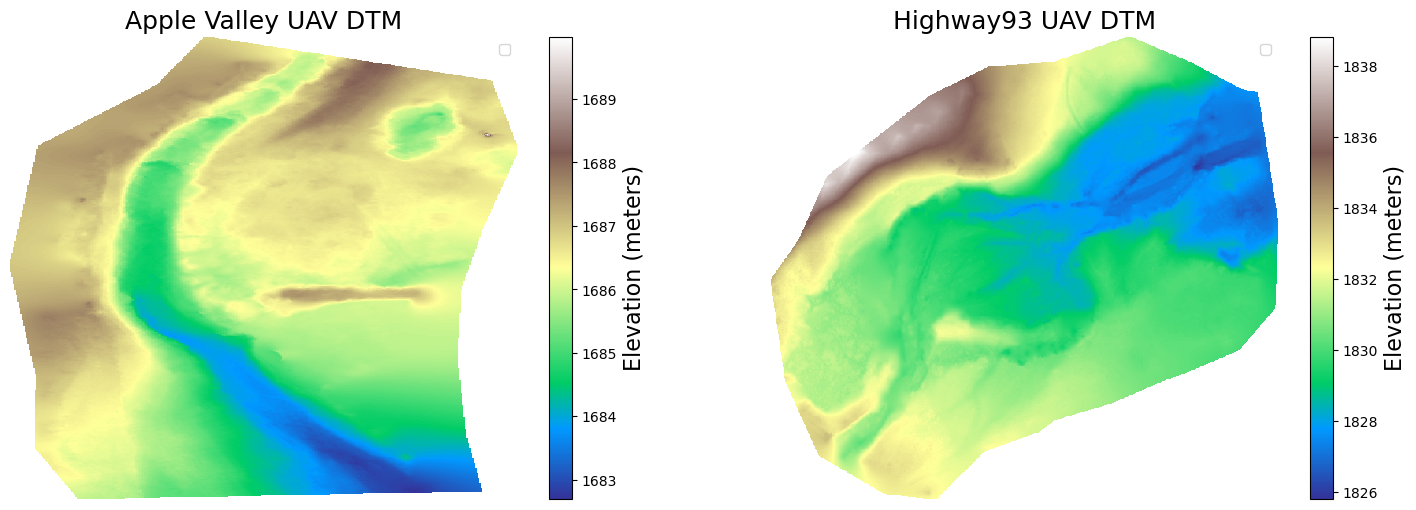

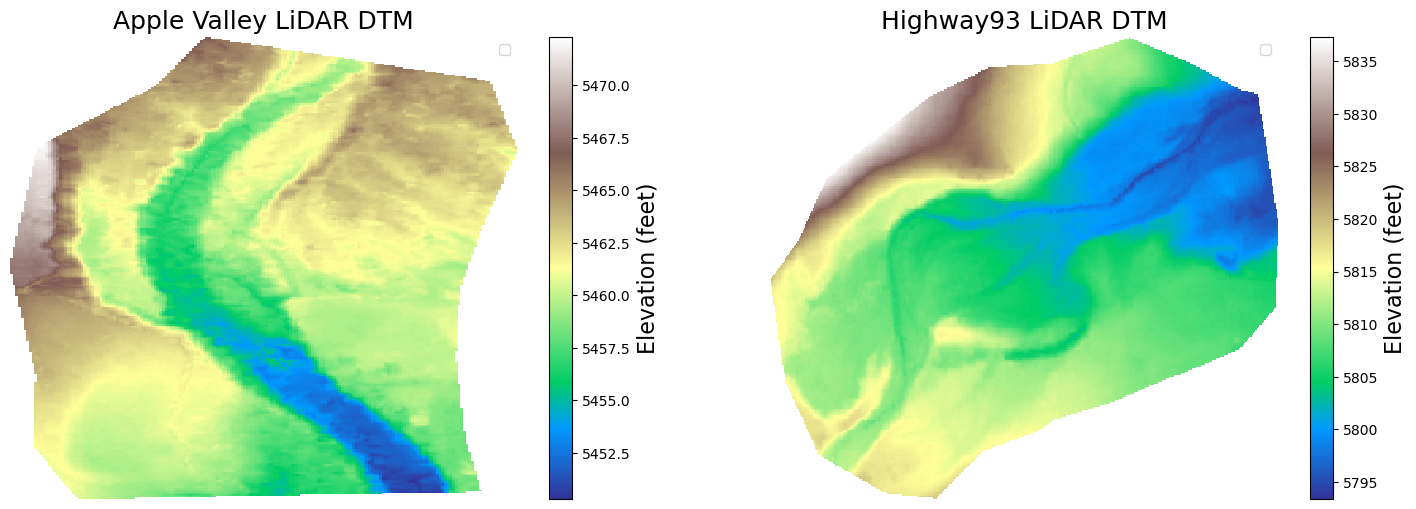

In [21]:
# Call function to plot UAV and Lidar DTMs
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
plot_title = ['Apple Valley UAV DTM', 
              'Highway93 UAV DTM']
for i,axe in enumerate(axes.flatten()):
    load_model.plot_model(model=site_data_dictionary[i]['uav_clipped_dtm'], 
                   title=plot_title[i],
                   cbar_label='Elevation (meters)',
                   coarsen=True, xpix=20, ypix=20,
                   fig=fig,ax=axe,
                   cmap='terrain')
    
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
plot_title = ['Apple Valley LiDAR DTM', 
              'Highway93 LiDAR DTM']
for i,axe in enumerate(axes.flatten()):
    load_model.plot_model(model=site_data_dictionary[i]['lidar_clipped_dtm'], 
                   title=plot_title[i],
                   cbar_label='Elevation (feet)',
                   coarsen=False,
                   fig=fig, ax=axe,
                   cmap='terrain')

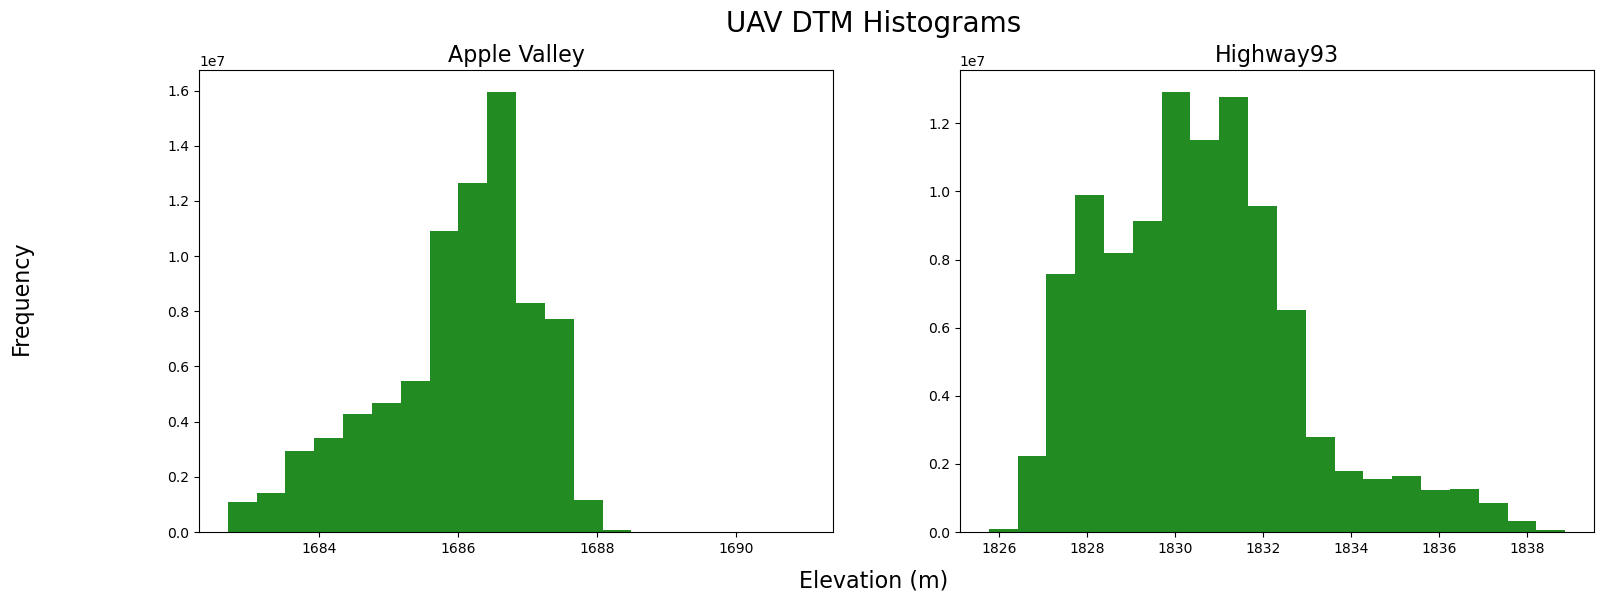

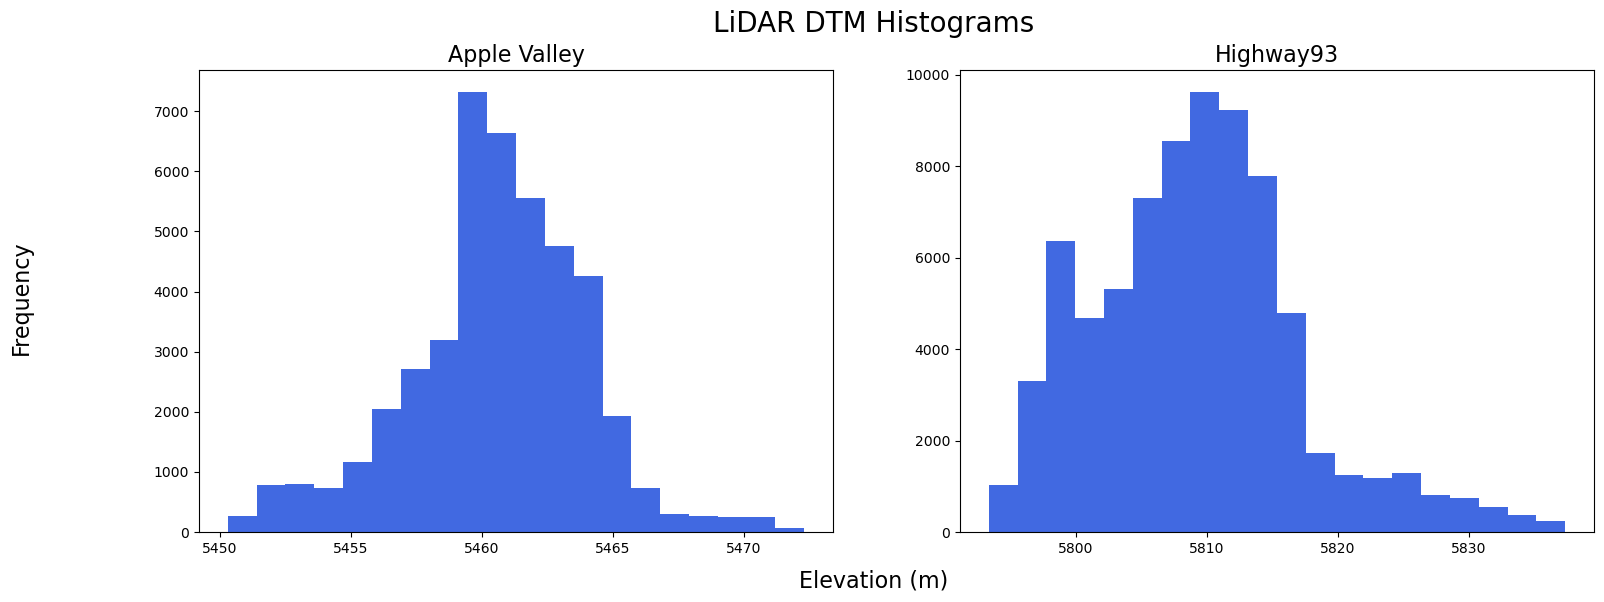

In [9]:
# Call function to plot histogram of lidar and UAV DTMs
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

plot_titles=['Apple Valley','Highway93']

for i, axe in enumerate(axes.flatten()):
    load_model.plot_hists(model=site_data_dictionary[i]['uav_clipped_dtm'], 
               titles=plot_titles[i],
               main_title='UAV DTM Histograms',
               color=('forestgreen'),
               ax=axe, 
               fig=fig)
    
# Call function to plot histogram of lidar DTMs
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, axe in enumerate(axes.flatten()):
    load_model.plot_hists(model=site_data_dictionary[i]['lidar_clipped_dtm'], 
               titles=plot_titles[i],
               main_title='LiDAR DTM Histograms',
               color=('royalblue'),
               ax=axe,
               fig=fig)

## Methods - Visualizing the UAV and LiDAR REMs with Raster Plots and Histograms
We created the following REMs in python with the open-source tool [REMMaker](https://github.com/OpenTopography/RiverREM/blob/main/riverrem/REMMaker.py). Comparing these outputs, we can see that although the resolution of the LiDAR data is lower, the two methods produced very similar REMs for the Highway 93 site. Both raster plots reveal the braided channels that characterize the floodplain, and the range of elevations match closely (~0-8) However, for the Apple Valley site, there are more evident differences between the UAV and LiDAR plots; for example, the LiDAR-generated REM did not pick up on the pond on the northeast side of the channel (low-elevation/white circle on the top right of the top figure, 'Apple Valley, UAV REM'), and it shows a higher elevation area to the west of the channel that doesn't appear on the UAV image.

The histograms show that the distributions of elevation frequencies for the two sites are similar. The UAV REMs contain higher counts overall because the UAV data has a resolution that is orders of magnitude higher than the LiDAR.

In [10]:
# Create LiDAR REMs for all sites with run_rem_maker_lidar function, add to dict
# Note, the run_rem_maker_lidar function set the directories and paths so that a new
# directory 'rem_maker_lidar' and file ''{}_lidar_dtm_REM.tif' is created
for site in site_data_dictionary:
    load_model.run_rem_maker_lidar(site_name=site['site_name'])
    lidar_rem_path = os.path.join(site['site_name'],
                                  'remmaker_lidar',
                                  '{}_lidar_clipped_dtm_REM.tif').format(site['site_name'])
    lidar_remmaker = rxr.open_rasterio(lidar_rem_path, masked=True)
    site['lidar_remmaker'] = lidar_remmaker*0.3048

The LiDAR REMMaker REM already exists. Not running REMMaker
The LiDAR REMMaker REM already exists. Not running REMMaker


In [11]:
# Create UAV REMs for all sites with run_rem_maker function, add to dict
# The function creates new directory and file similar to the run_rem_maker_lidar function
for site in site_data_dictionary:
    load_model.run_rem_maker(site_name=site['site_name'], k=None)
    uav_rem_path = os.path.join(site['site_name'],
                                  'remmaker',
                                  '{}_clipped_dtm_REM.tif').format(site['site_name'])
    site['uav_remmaker'] = rxr.open_rasterio(uav_rem_path, masked=True)

The UAV REMMaker REM already exists. Not running REMMaker
The UAV REMMaker REM already exists. Not running REMMaker


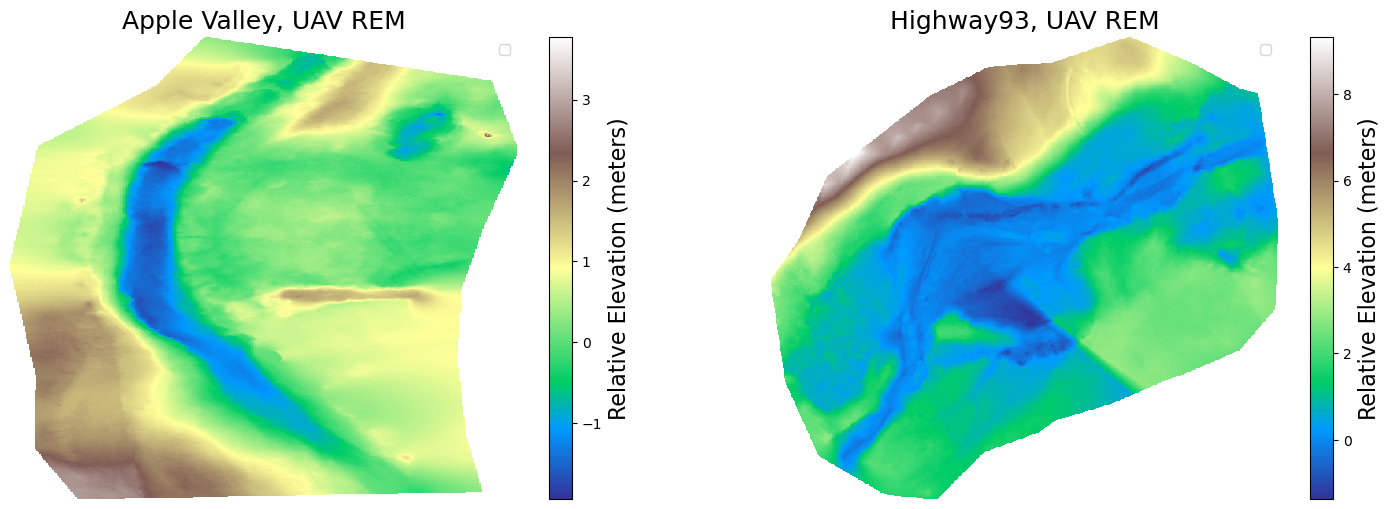

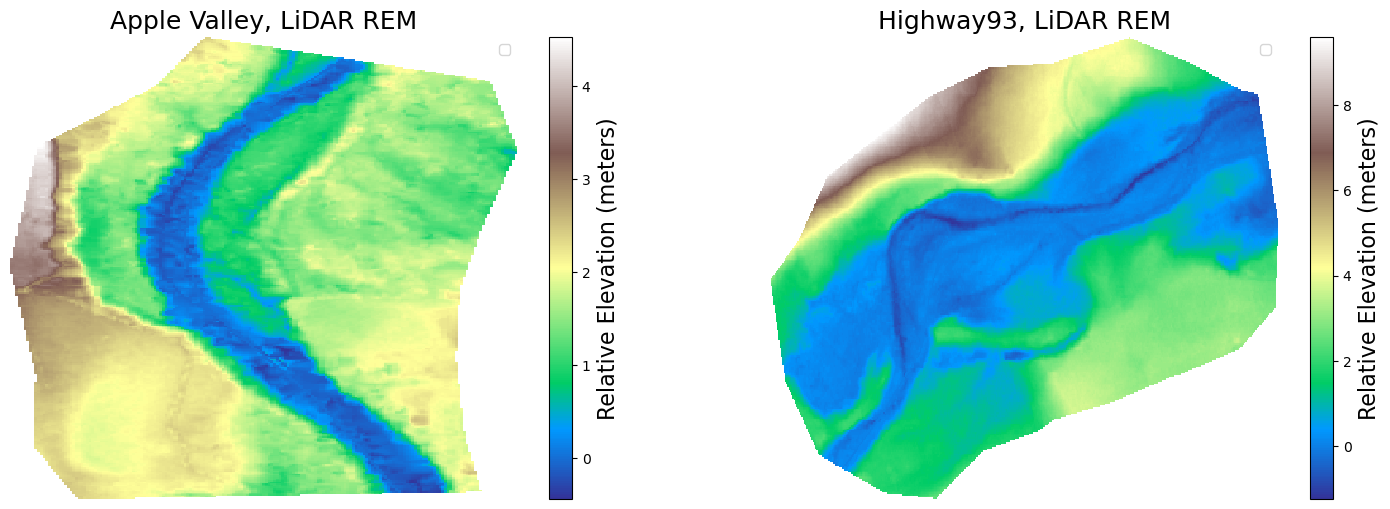

In [22]:
# Call function to plot UAV and LiDAR REMs 

# UAV REMs (REMMaker Tool)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
plot_title = ['Apple Valley, UAV REM', 
              'Highway93, UAV REM']
for i,axe in enumerate(axes.flatten()):
    load_model.plot_model(model=site_data_dictionary[i]['uav_remmaker'], 
                   title=plot_title[i],
                   cbar_label='Relative Elevation (meters)',
                   coarsen=True,
                   xpix=20,
                   ypix=20,
                   fig=fig,
                   ax=axe, 
                   cmap='terrain')
    
# Lidar REMs (REMMaker Tool)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
plot_title = ['Apple Valley, LiDAR REM', 
              'Highway93, LiDAR REM']
for i,axe in enumerate(axes.flatten()):
    load_model.plot_model(model=site_data_dictionary[i]['lidar_remmaker'], 
                   title=plot_title[i],
                   cbar_label='Relative Elevation (meters)',
                   coarsen=False,
                   fig=fig,
                   ax=axe,
                   cmap='terrain')

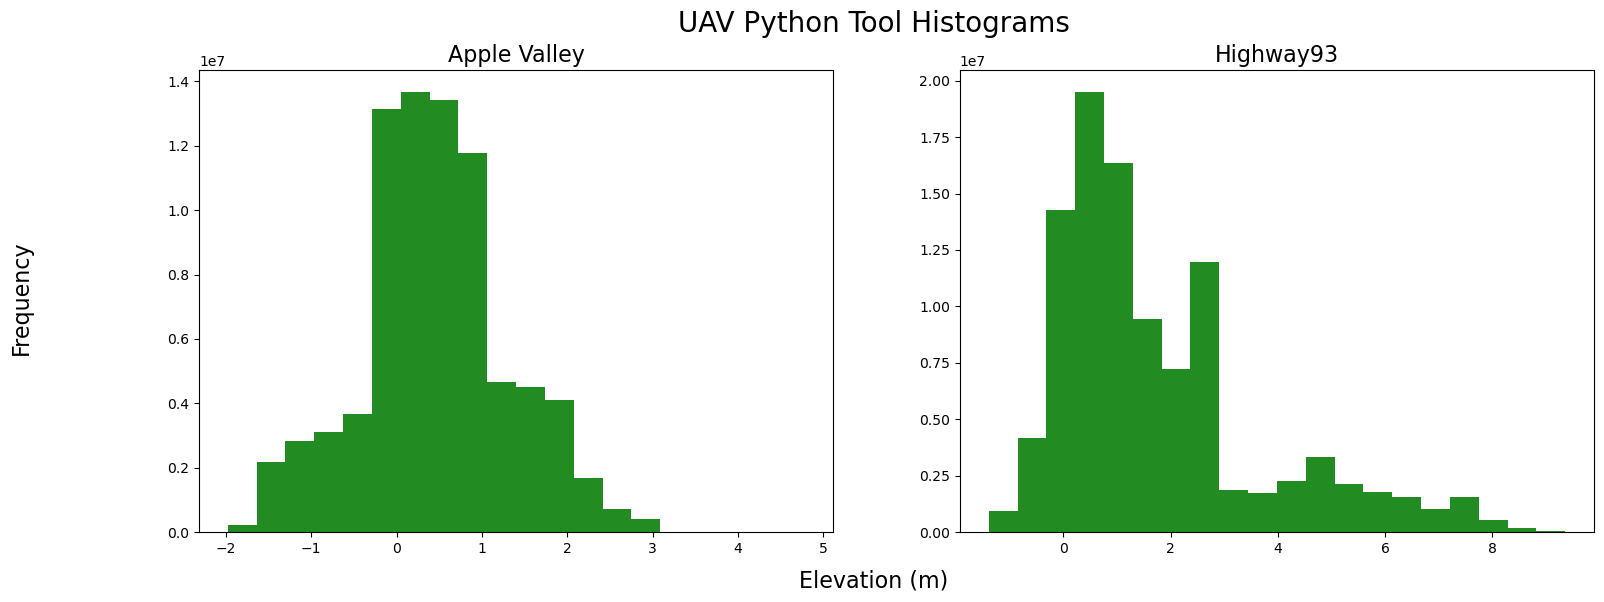

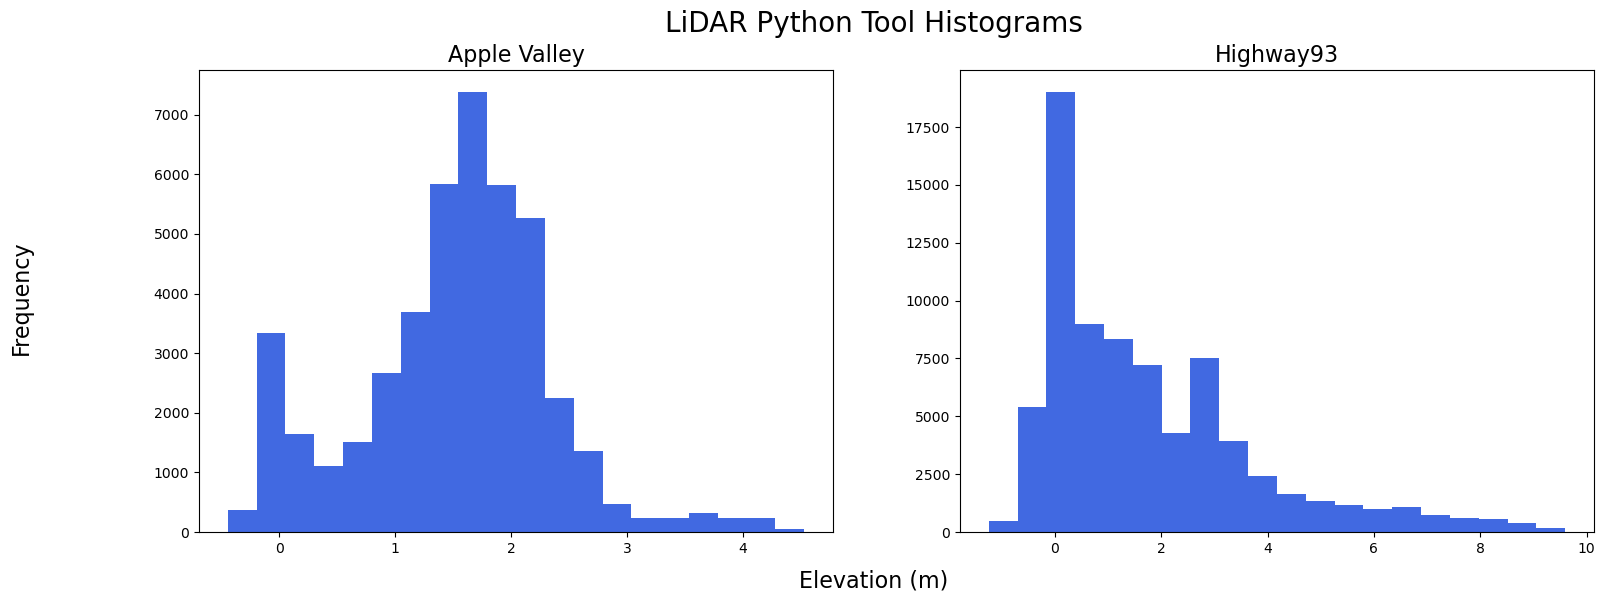

In [13]:
# Call function to plot histograms of LiDAR and UAV REMs

# UAV REMs (REMMaker Tool)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
plot_title = ['Apple Valley',
              'Highway93']

for i, axe in enumerate(axes.flatten()):
    load_model.plot_hists(model=site_data_dictionary[i]['uav_remmaker'], 
               titles=plot_title[i],
               main_title='UAV Python Tool Histograms',
               color=('forestgreen'),
               fig=fig,
               ax=axe)
    
# LiDAR REMs (REMMaker Tool)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
plot_title = ['Apple Valley',
              'Highway93']

for i, axe in enumerate(axes.flatten()):
    load_model.plot_hists(model=site_data_dictionary[i]['lidar_remmaker'], 
               titles=plot_title[i],
               main_title='LiDAR Python Tool Histograms',
               color=('royalblue'),
               fig=fig,
               ax=axe)

## Application and Discussion - Flood Simulation
A **flood map** shows the area that would become inundated if the water level rises to a given elevation. We conducted a very basic simulation where we sequentially increased the elevation to a threshold elevation that represents the water level from a flooding event, and assumed that any pixel in the REM raster below the threshold would become inundated.

The plots below demonstrate how a more complex and connected floodplain can help mitigate flood effects by storing water as water levels rise. It is able to do this because of the low elevation pools and channels that can effectively hold water because "water always takes the low road". To view the animated simulation, please go to our github site and run this notebook [taking-the-low-road-blog.ipynb](https://github.com/JuliaSobczak/st-vrain-rem)

In [14]:
# Create lists of floodmaps at different water level thresholds
threshold_values = np.arange(-.5, .5, 0.05)
# threshold_lidar_das = []
# threshold_uav_das = []
# uav_area_list = []
# lidar_area_list = []

applevalley_flood_dictionary = load_model.flood_map(threshold_values,
                                                    lidar_rem = site_data_dictionary[0]['lidar_remmaker'])
# threshold_lidar_das = []
# threshold_uav_das = []
# uav_area_list = []
# lidar_area_list = []
highway93_flood_dictionary = load_model.flood_map(threshold_values,
                                                  lidar_rem = site_data_dictionary[1]['lidar_remmaker'])

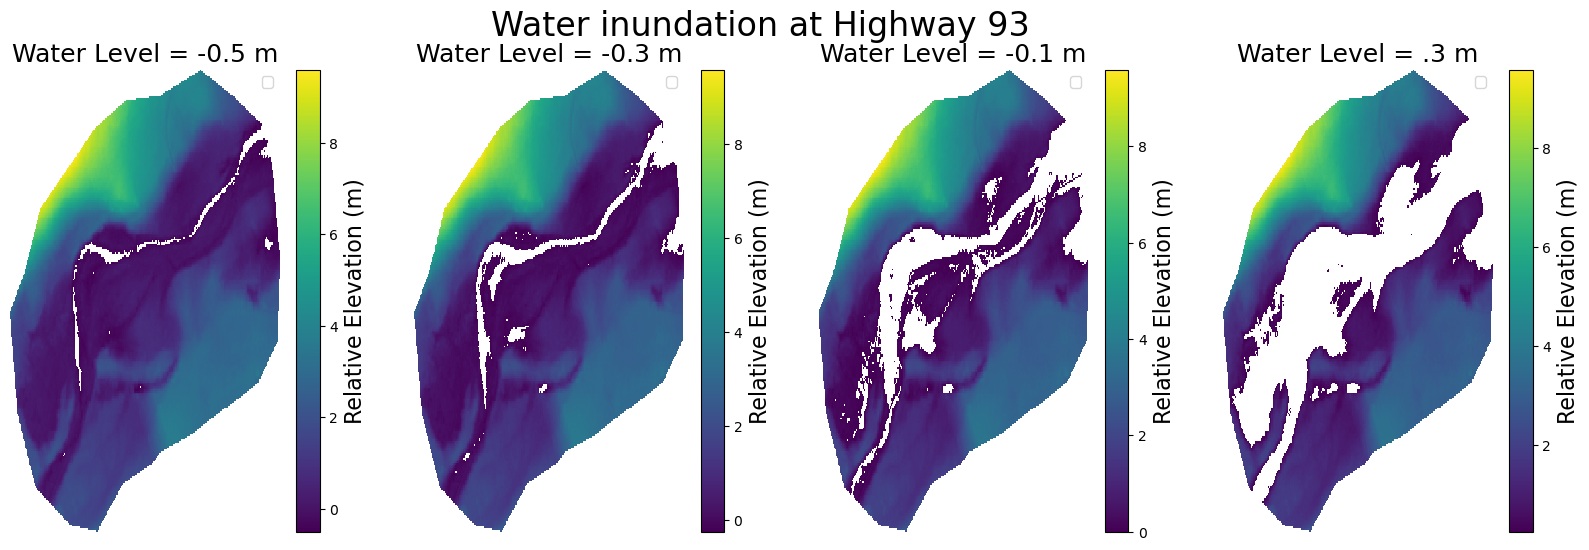

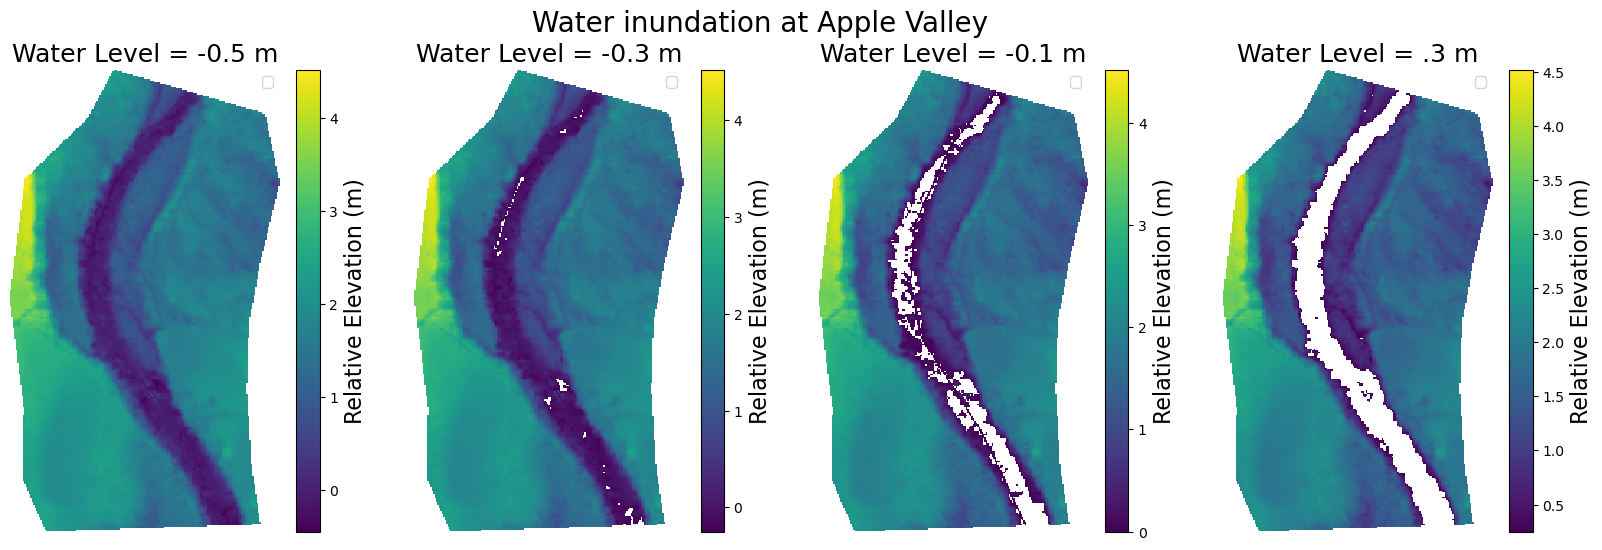

In [15]:
# Plot the lidar floodmaps - update subplots to match len(threshold_values)
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
plot_title = ['Water Level = -0.5 m', 'Water Level = -0.3 m', 
              'Water Level = -0.1 m', 'Water Level = .3 m']
fig.suptitle('Water inundation at Highway 93', fontsize=24)

for i, axe in enumerate(axes.flatten()):
    load_model.plot_model(model=highway93_flood_dictionary['threshold_lidar_das'][i*5], 
               title=plot_title[i],
               cbar_label='Relative Elevation (m)',
               coarsen=False,
                #   xpix=100,
                 #  ypix=100,
                   fig=fig,
                   ax=axe,
                   cmap='viridis')

fig, axes = plt.subplots(1, 4, figsize=(20, 6))
plot_title = ['Water Level = -0.5 m', 'Water Level = -0.3 m', 
              'Water Level = -0.1 m', 'Water Level = .3 m']
fig.suptitle('Water inundation at Apple Valley', fontsize=20)

for i, axe in enumerate(axes.flatten()):
    load_model.plot_model(model=applevalley_flood_dictionary['threshold_lidar_das'][i*5], 
               title=plot_title[i],
               cbar_label='Relative Elevation (m)',
               coarsen=False,
               #    xpix=100,
                #   ypix=100,
                   fig=fig,
                   ax=axe, 
                   cmap='viridis')

In the simulation below, the Highway 93 site has more complexity and is well-connected to its floodplain. Noticed how the white water slowly pools and spreads out, taking advantage of the multiple side channels and depressions. It's apparent that increased connectivity of the system means greater inundation and less water downstream.

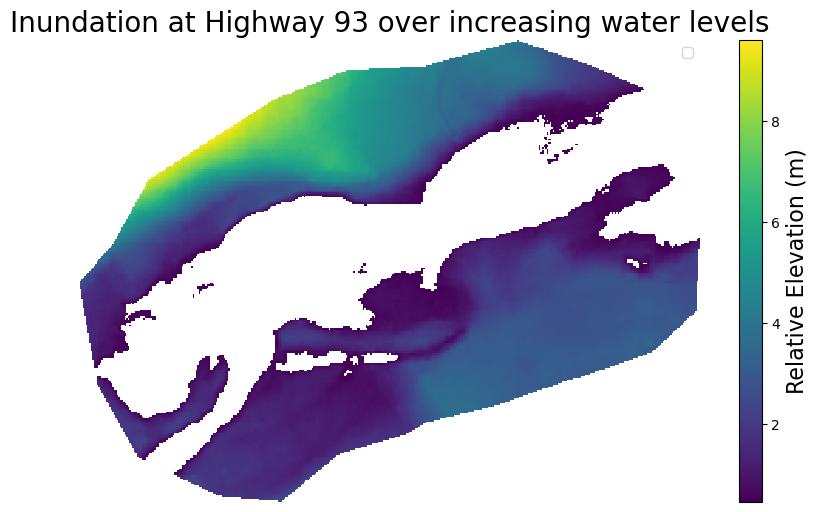

In [19]:
# Highway 93 simulation
for threshold_da in highway93_flood_dictionary['threshold_lidar_das']:
    load_model.plot_floodmap(plot_da=threshold_da, site='Highway 93', vmin = 0, vmax = 8)
    sleep(0.01)
    clear_output(wait=True)

In contrast, the Apple Valley site has no accessible side channels and the stream is too low to access its floodplain. As the water level increases, the channel remains the same. The energy of the flood will remain at the same level as it passes through this system, which may erode the banks and cause destruction downstream. Overall, decreased connectivity means less inundation and more water traveling downstream.

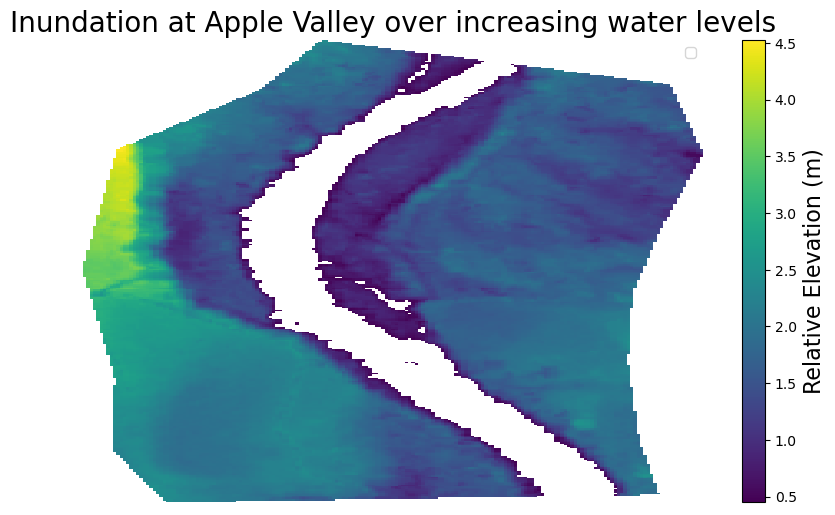

In [20]:
# Apple Valley simulation
for threshold_da in applevalley_flood_dictionary['threshold_lidar_das']:
    load_model.plot_floodmap(plot_da=threshold_da, site='Apple Valley', vmin = 0, vmax = 2.5)
    sleep(0.01)
    clear_output(wait=True)

# Resources
American Rivers. 2016. Reconnecting Rivers to Floodplains Returning natural functions to restore rivers and benefit communities. https://www.americanrivers.org/wp-content/uploads/2016/06/ReconnectingFloodplains_WP_Final.pdf*

Boulder County. 2022. Floodplain Information. <https://bouldercounty.gov/transportation/floodplain-mapping/frequently-asked-questions/>.

FISRWG (Federal Interangency Stream Restoration Working Group). 1998.  Stream Corridor Restoration:  Principles, Processes, and Practices.  GPO Item No. 0120-A; SuDocs No. A 57.6/2:EN3/PT.653.  ISBN-0-934213-59-3.

USGS (United States Geological Survey). 2018. The 100-year Flood. By Water Science School. <https://www.usgs.gov/special-topics/water-science-school/science/100-year-flood>.

Also see our github repository: [https://github.com/JuliaSobczak/st-vrain-rem](https://github.com/JuliaSobczak/st-vrain-rem)

In [18]:
# Move to the local repository directory where this notebook is saved
repo_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'st-vrain-rem')
try:
    os.chdir(repo_dir)
except:
    print('{} does not exist. Please make sure you forked the '
          'repository to the correct location. See README' 
          'for instructions'.format(repo_dir))
else:
    print('Changed directory to {}'.format(repo_dir))
    !jupyter nbconvert --to html --no-input taking-the-low-road-blog.ipynb

Changed directory to /Users/lchipman/earth-analytics/st-vrain-rem
Variables may not be used as commands. In fish, please define a function or use 'eval $CONDA_EXE'.
- (line 1): $CONDA_EXE shell.fish $cmd $argv
            ^
in command substitution
	called on line 67 of file -

in function 'conda'
	called on line 147 of file -
	with parameter list 'activate base'

from sourcing file -
	called on line 11 of file ~/.config/fish/config.fish

from sourcing file ~/.config/fish/config.fish
	called during startup

[NbConvertApp] Converting notebook taking-the-low-road-blog.ipynb to html
[NbConvertApp] Writing 2705541 bytes to taking-the-low-road-blog.html
